In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor
import shap

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [6]:
ordinal_data = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/data_ordinal.csv') 
frame = ordinal_data.copy()
frame0 = frame.copy()
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_scorer(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

frame = frame[frame['SaleCondition'] == 4]


In [7]:
dataset = 'ordinal'
model_name = 'xgboost_tuned'
trial = "onlyNormalCondition"


#the features will be X (independent variables)
X = frame.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = frame['SalePrice']
y_array = y.values

params =  {'max_depth': 3,
             'learning_rate': 0.0836719064919561,
             'n_estimators': 629,
             'min_child_weight': 2,
             'colsample_bytree': 0.2015968025244805,
             'subsample': 0.7345072578143232,
             'reg_alpha': 0.9256222240627585,
             'reg_lambda': 0.16575971012532154}

#Input parameters into the model
best_model = xgb.XGBRegressor(**params)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')


# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)

# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)


In [8]:
# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores, '\n')
# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n') 

Cross-Validation Scores: [0.95155012 0.95090586 0.93213528 0.94454715 0.94850518] 

Mean R^2: 0.9455287175336885 



In [13]:
#  #Split your training and testing sets of data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# # Train the model on the training set
# best_model.fit(X_train, y_train)

# # Make predictions on the test set
# predictions = best_model.predict(X_test)

NameError: name 'X_train' is not defined

In [10]:
# Perform cross-validation and obtain predictions
predicted_values = cross_val_predict(best_model, X, y, cv=kf)

# Calculate residuals
residuals = y - predicted_values


In [12]:
# Assuming you have a trained CatBoostRegressor model named 'catboost_model'
feature_importance = best_model.feature_importances_

# Get feature names from the training dataset
your_feature_names = X.columns  # Replace 'X' with your feature matrix

# Create a DataFrame for better handling
feature_importance_df = pd.DataFrame({'Feature': your_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='blue')
plt.xlabel('Importance')
plt.title('Top 10 Features - CatBoost Feature Importance')
plt.show()

NotFittedError: need to call fit or load_model beforehand

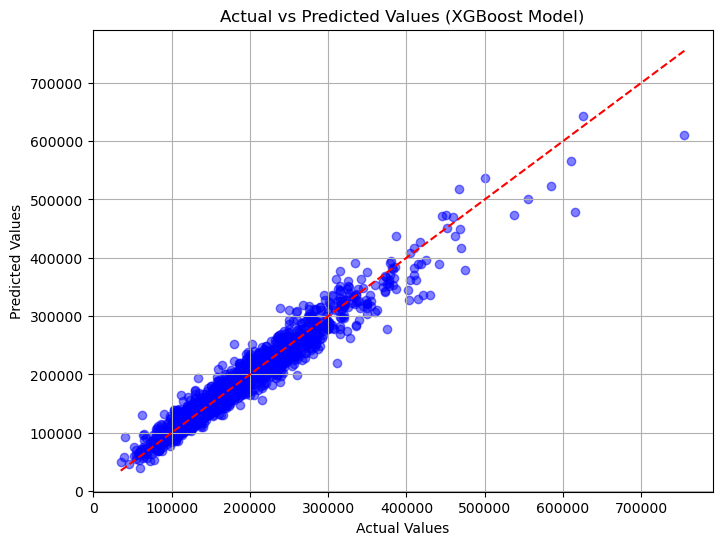

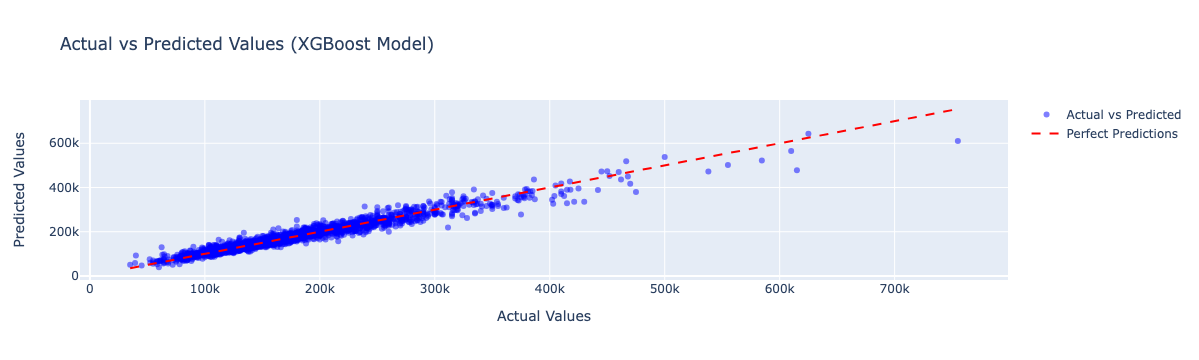

In [15]:
# Plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, predicted_values, color='blue', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (XGBoost Model)')
plt.grid(True)
plt.show()

# Create a scatter plot
scatter_plot = go.Scatter(x=y, y=predicted_values, mode='markers', 
                          marker=dict(color='blue', opacity=0.5),
                          name='Actual vs Predicted')

# Add a diagonal line representing perfect predictions
diagonal_line = go.Scatter(x=[min(y), max(y)], y=[min(y), max(y)],
                           mode='lines', line=dict(color='red', dash='dash'),
                           name='Perfect Predictions')

# Layout
layout = go.Layout(title='Actual vs Predicted Values (XGBoost Model)',
                   xaxis=dict(title='Actual Values'),
                   yaxis=dict(title='Predicted Values'),
                   showlegend=True)

# Create figure
scatter_fig = go.Figure(data=[scatter_plot, diagonal_line], layout=layout)

# Show plot
scatter_fig.show()


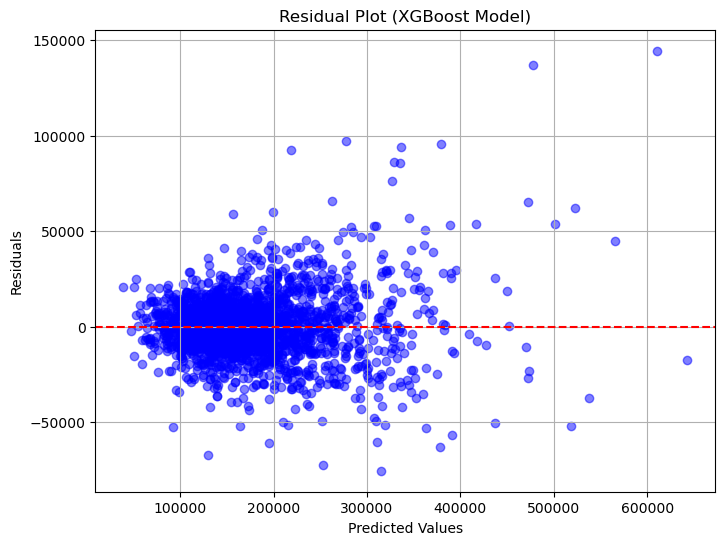

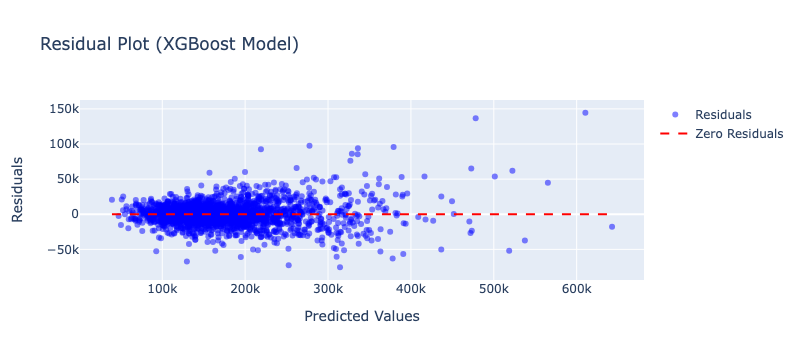

In [16]:


# Plotting residuals against predicted values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost Model)')
plt.grid(True)
plt.show()

# Create a scatter plot
residual_plot = go.Scatter(x=predicted_values, y=residuals, mode='markers', 
                           marker=dict(color='blue', opacity=0.5),
                           name='Residuals')

# Add a horizontal line at y=0
horizontal_line = go.Scatter(x=[min(predicted_values), max(predicted_values)], y=[0, 0],
                             mode='lines', line=dict(color='red', dash='dash'),
                             name='Zero Residuals')

# Layout
layout = go.Layout(title='Residual Plot (XGBoost Model)',
                   xaxis=dict(title='Predicted Values'),
                   yaxis=dict(title='Residuals'),
                   showlegend=True)

# Create figure
residual_fig = go.Figure(data=[residual_plot, horizontal_line], layout=layout)

# Show plot
residual_fig.show()


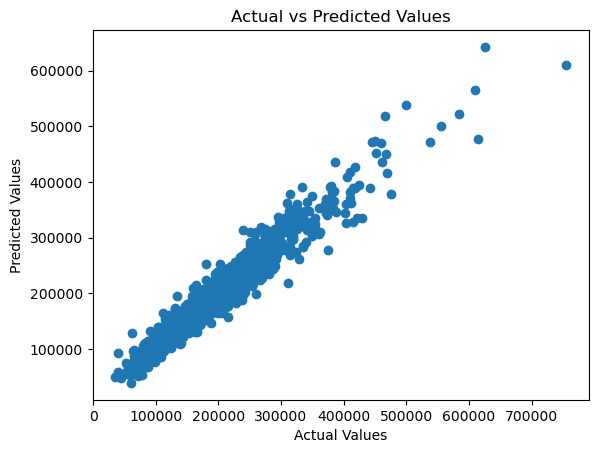

In [17]:
# Plotting actual vs predicted values
plt.scatter(y, predicted_values)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [19]:
best_model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.2015968025244805, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0836719064919561, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=629, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

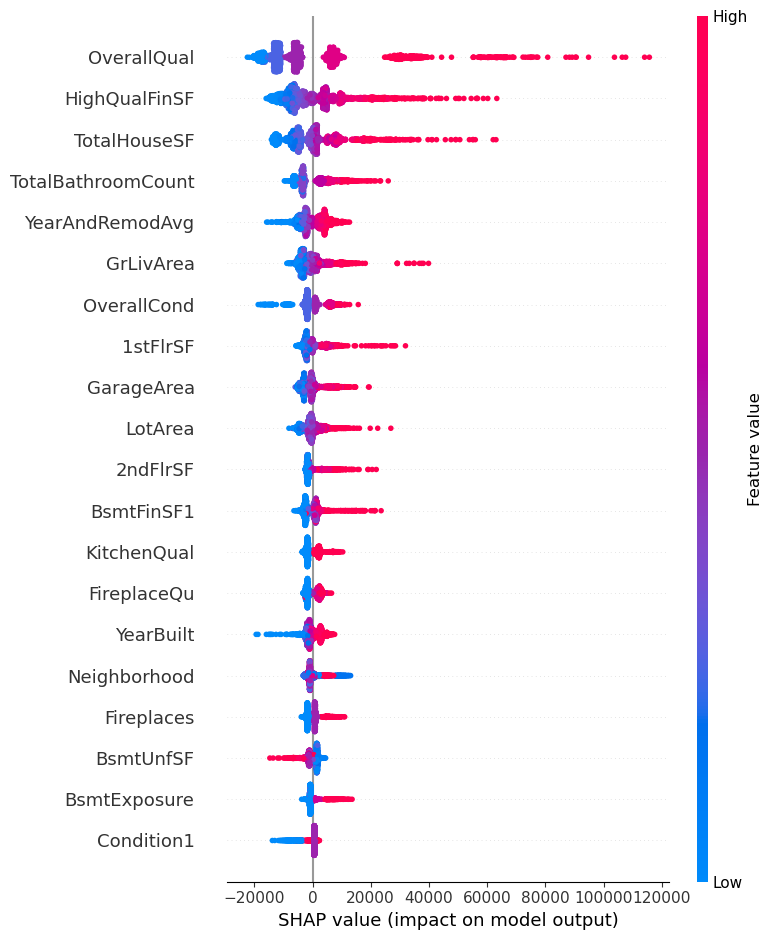

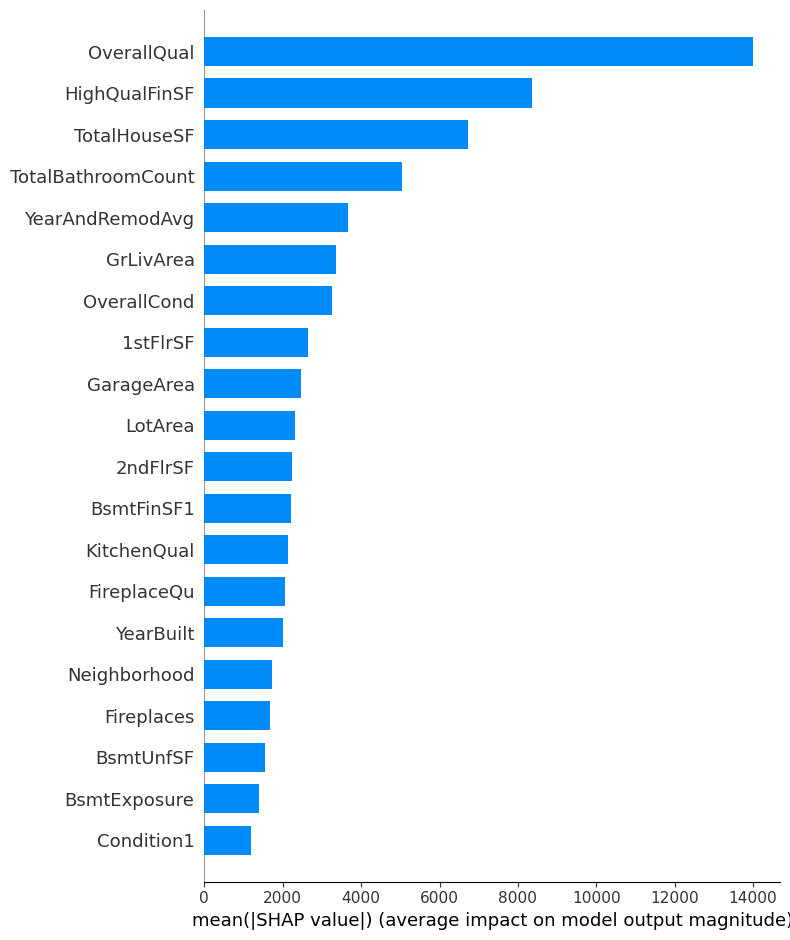

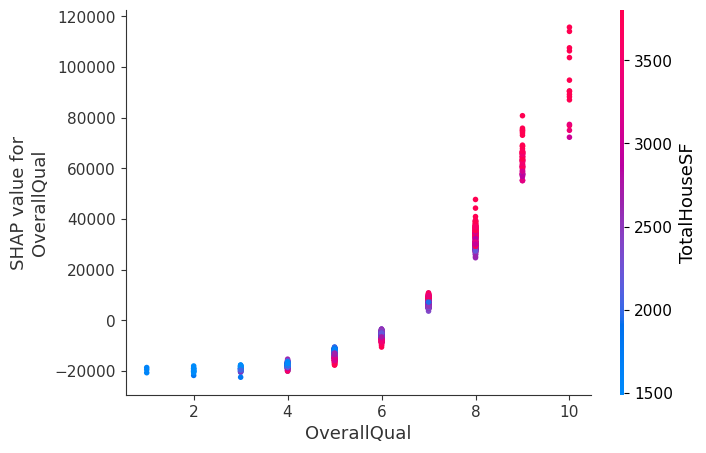

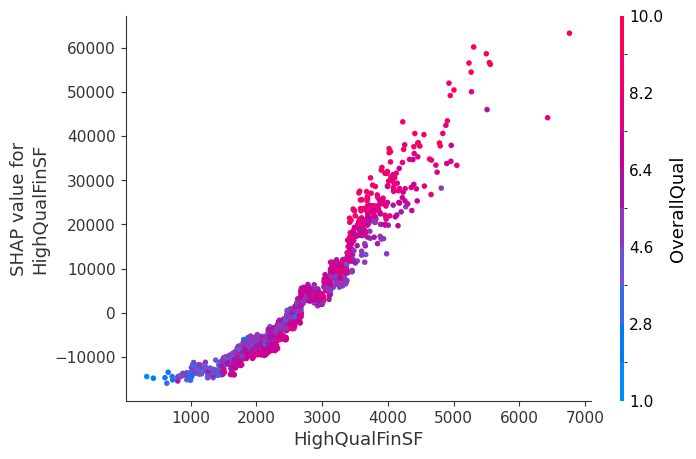

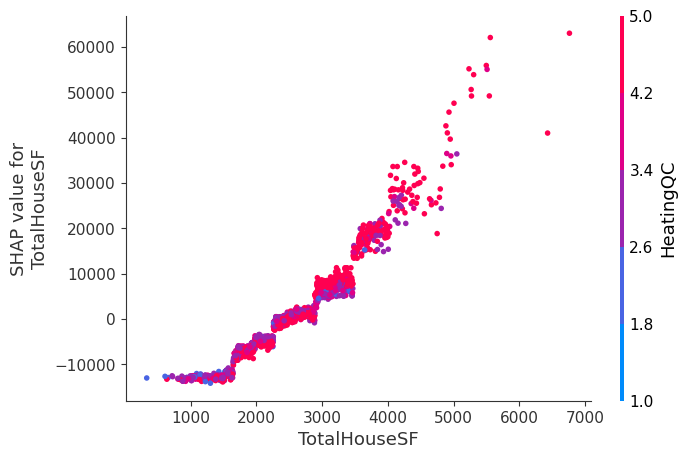

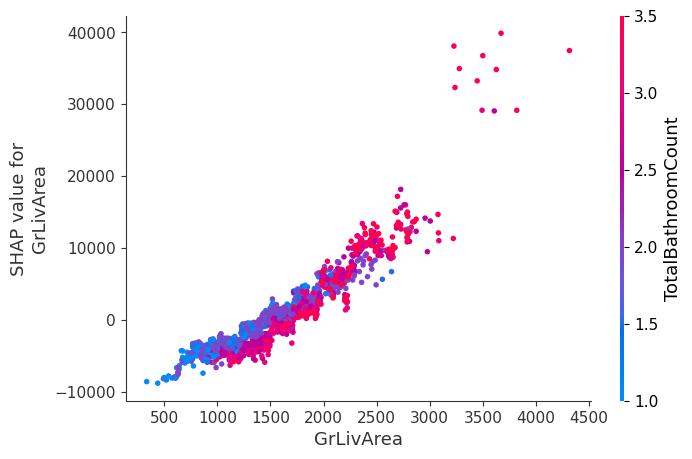

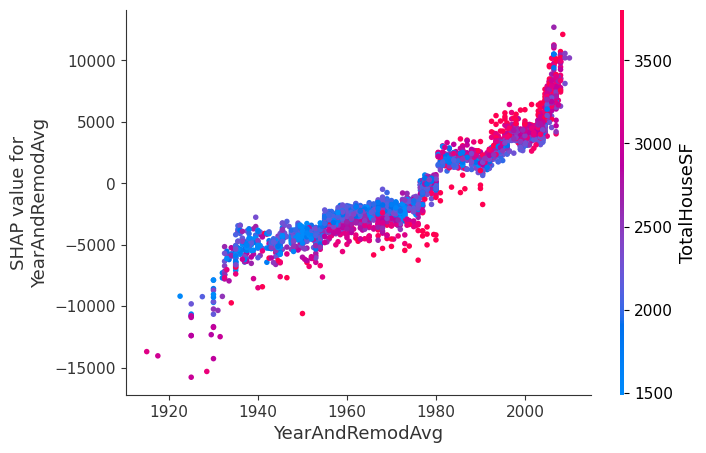

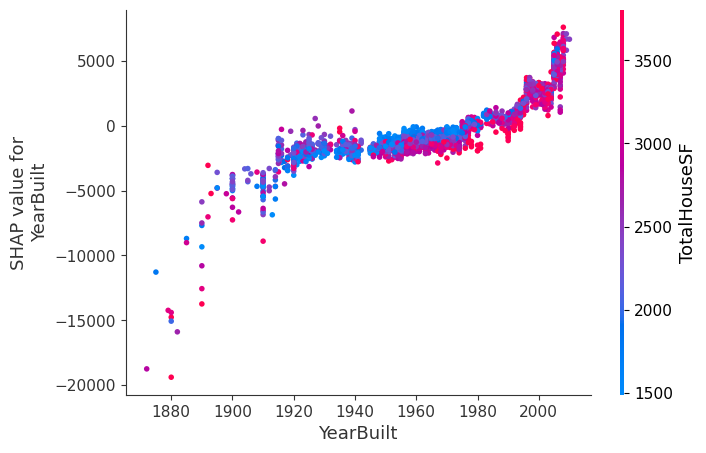

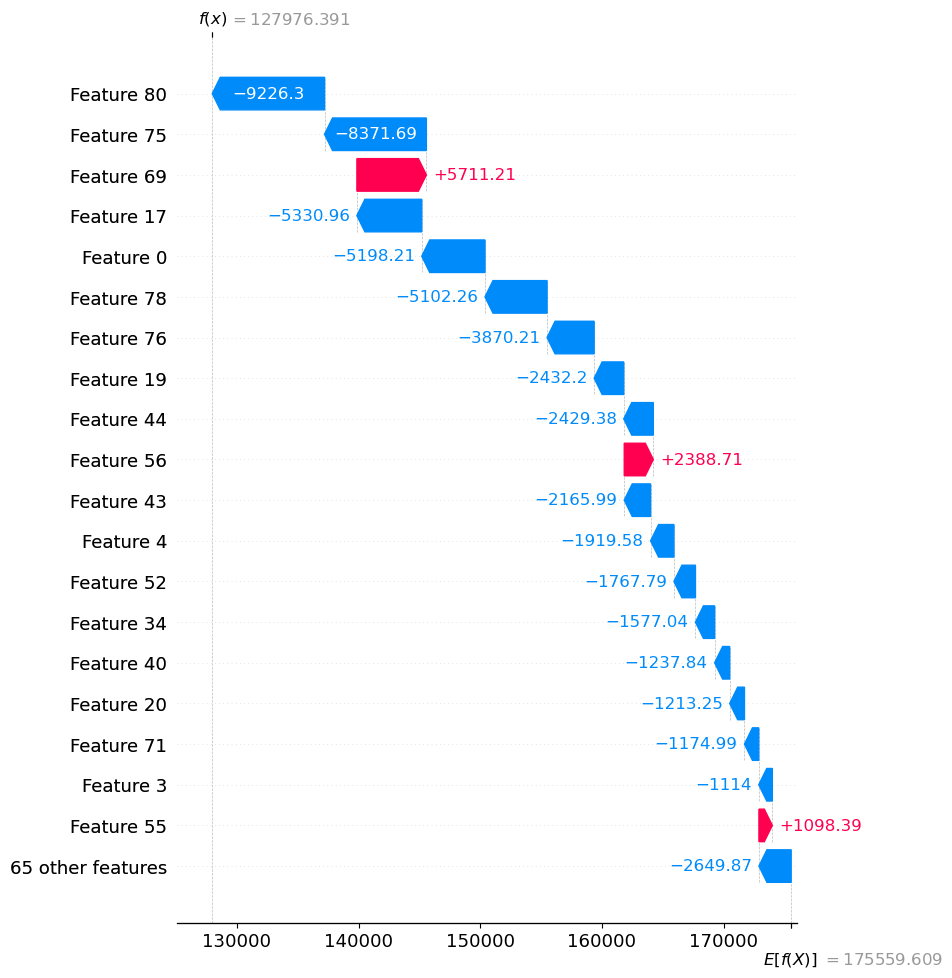

In [51]:
# Use the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X)

# 1. Summary Plot
shap.summary_plot(shap_values, X)

# 2. Summary Bar Plot
shap.summary_plot(shap_values, X, plot_type="bar", show=False)

# 3. Dependence Plot
shap.dependence_plot("OverallQual", shap_values, X)
shap.dependence_plot("HighQualFinSF", shap_values, X)
shap.dependence_plot("TotalHouseSF", shap_values, X)
shap.dependence_plot("GrLivArea", shap_values, X)

#shap.dependence_plot("KitchenQual", shap_values, X_test)
shap.dependence_plot("YearAndRemodAvg", shap_values, X)
shap.dependence_plot("YearBuilt", shap_values, X)



# 4. Force Plot (for a specific prediction)
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

# 5. Waterfall Plot (for a specific prediction)
shap.waterfall_plot(shap.Explanation(values=shap_values[0, :], base_values=explainer.expected_value), max_display=20)


In [21]:
feature_names = X.columns.tolist()

# Create a DataFrame with SHAP values
shap_df = pd.DataFrame(shap_values, columns=feature_names)
shap_df.describe()

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.0,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.0,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000
mean,-239.926300,35.511879,4.558093,105.104813,-140.500443,3.150360,-5.089588,19.465309,-18.230669,0.0,-9.184189,1.895338,87.700478,14.468629,-1.576775,23.600920,-8.820882,231.089859,89.290291,19.292927,-90.740181,-8.574772,-0.107227,-8.537624,7.465737,9.939936,-159.345490,-107.804619,0.960973,-154.775269,-30.708565,2.402845,57.845551,-13.164850,-45.181850,-4.782662,12.474881,-0.201277,-49.035645,5.167366,-134.708313,59.105873,3.243175,4.150111,-85.166451,-1.101826,24.547504,-3.717377,111.867424,-8.809891,-34.698223,22.893124,-12.346127,-196.989899,24.592237,-23.043074,121.106369,-40.918175,-27.129383,-94.628181,82.203773,-300.219452,-0.388818,31.643919,5.897805,10.398613,-8.283050,-28.021927,-0.589716,34.748371,-5.266510,-1.118975,-8.204784,-2.040399,0.0,501.330383,56.987293,-124.429176,-30.223061,-3.877966,143.177689,44.148430,11.544096,176.378571
std,4772.973145,786.876404,1106.117798,1384.439331,3219.829590,231.041641,463.406433,495.698517,489.417236,0.0,633.334351,433.027069,2585.513916,2085.612305,290.361755,904.246582,532.485596,19234.044922,4419.122070,2606.695557,1225.345093,451.254089,495.090851,1191.872192,239.722763,122.374557,1992.943970,810.852539,256.520966,1022.146606,1150.409546,365.789032,2288.686035,661.166443,3226.057861,109.022812,658.023438,2017.592773,983.354431,99.014603,1189.900879,1340.985229,93.079742,3795.354248,3042.369141,185.635361,511.022400,68.837967,131.620514,82.730850,466.293060,602.327026,2495.281982,824.922546,2082.354980,2176.824463,2156.378174,616.671570,1484.225464,408.176331,748.996460,3564.093262,104.076805,581.914429,426.784210,711.899963,720.127869,799.570801,201.482880,1827.109253,88.878456,1038.387573,232.612076,176.518417,0.0,9639.212891,5746.074707,1257.451782,4248.306152,1452.088379,11108.236328,876.564941,946.363708,455.689148
min,-8839.781250,-2848.458252,-7035.485352,-6639.058105,-8117.947266,-4891.417480,-583.063049,-961.061707,-1929.983398,0.0,-5052.898438,-371.321106,-3234.186035,-13812.859375,-5038.883301,-3064.266113,-1194.626953,-22402.490234,-18689.19

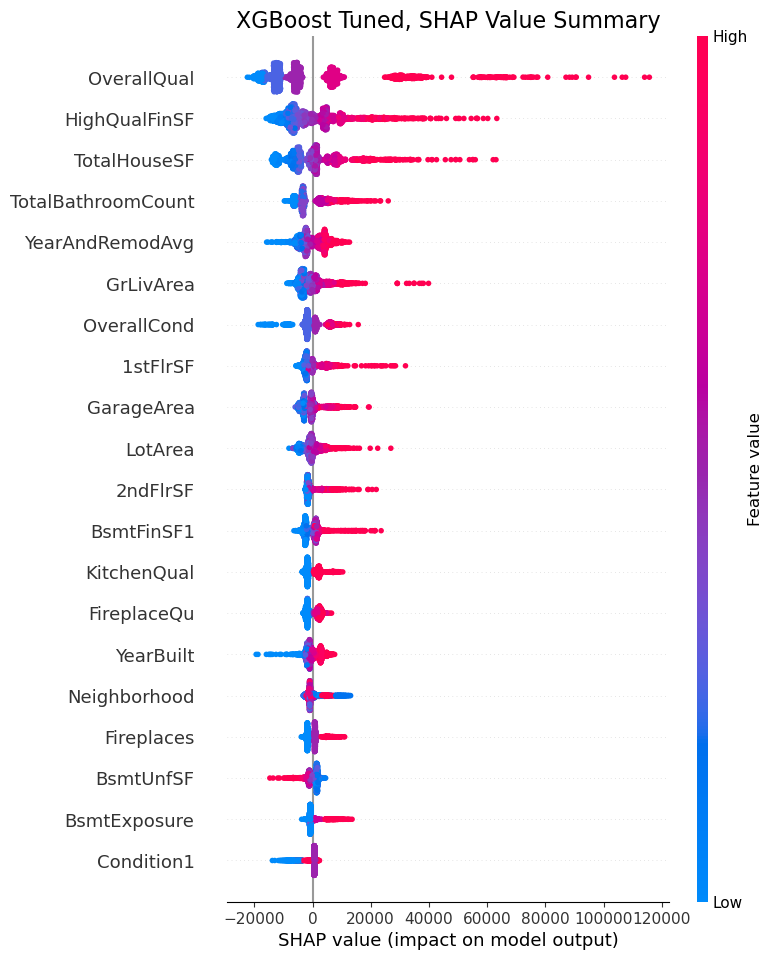

In [46]:
# 1. Summary Plot
shap.summary_plot(shap_values, X, show = False)
plt.title('XGBoost Tuned, SHAP Value Summary', fontsize=16)

plt.show()

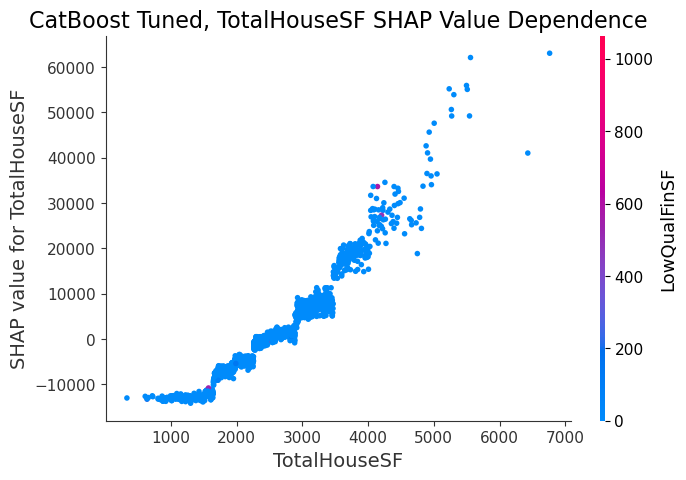

In [22]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index="LowQualFinSF", show=False)

plt.title('CatBoost Tuned, TotalHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);
plt.show()

In [23]:
frame.LowQualFinSF.value_counts()

0       2379
80         3
205        2
360        2
384        1
697        1
420        1
232        1
140        1
312        1
259        1
473        1
481        1
572        1
53         1
390        1
234        1
1064       1
108        1
120        1
397        1
512        1
362        1
144        1
528        1
514        1
156        1
479        1
Name: LowQualFinSF, dtype: int64

In [24]:
(frame.LowQualFinSF.value_counts().sum() - 2379) / frame.LowQualFinSF.value_counts().sum() * 100

1.2863070539419086

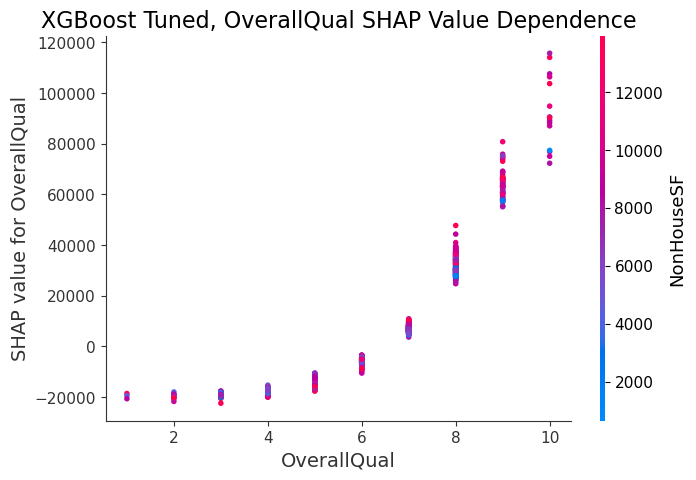

In [50]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("OverallQual", shap_values, X, interaction_index="NonHouseSF", show=False)

plt.title('XGBoost Tuned, OverallQual SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for OverallQual', fontsize=14)
plt.xlabel('OverallQual', fontsize=14);
plt.show()

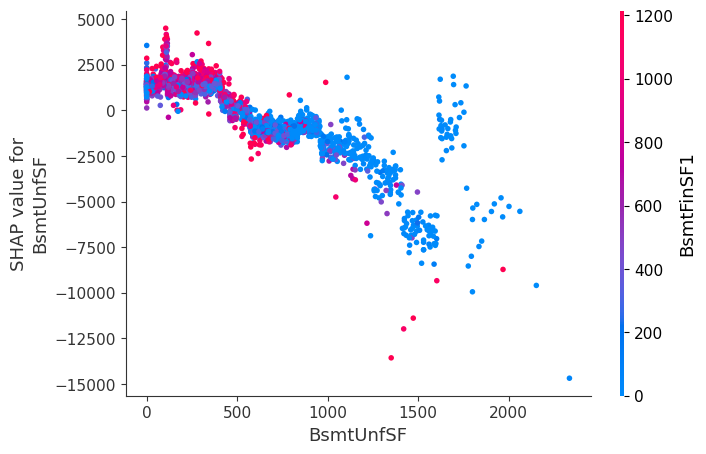

In [26]:
shap.dependence_plot("BsmtUnfSF", shap_values, X, interaction_index="BsmtFinSF1")


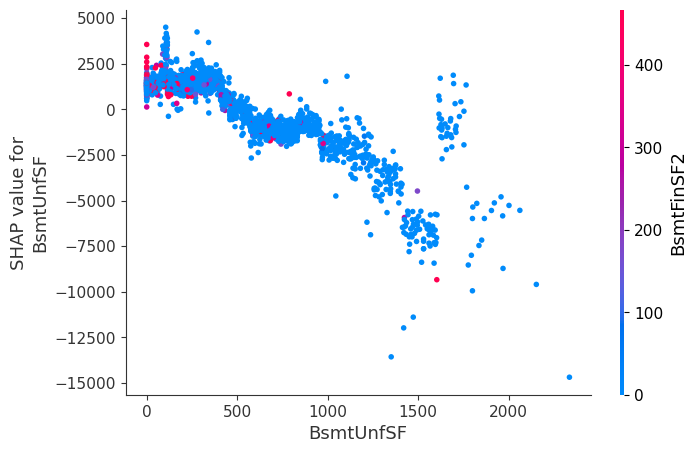

In [38]:
shap.dependence_plot("BsmtUnfSF", shap_values, X, interaction_index="BsmtFinSF2")


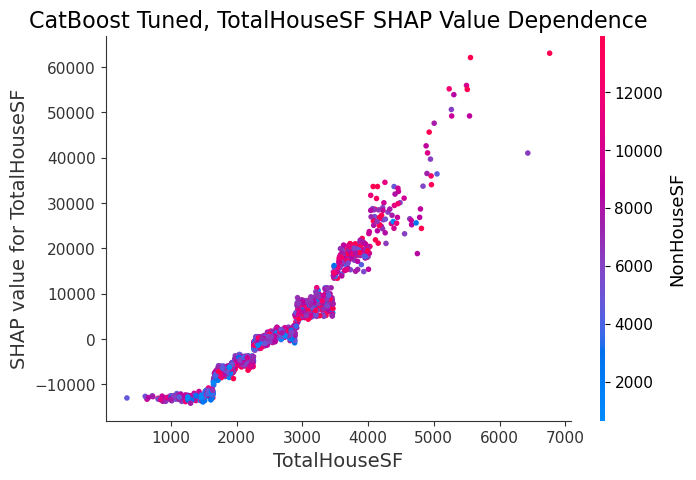

In [27]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index="NonHouseSF", show=False)

plt.title('CatBoost Tuned, TotalHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);
plt.show()

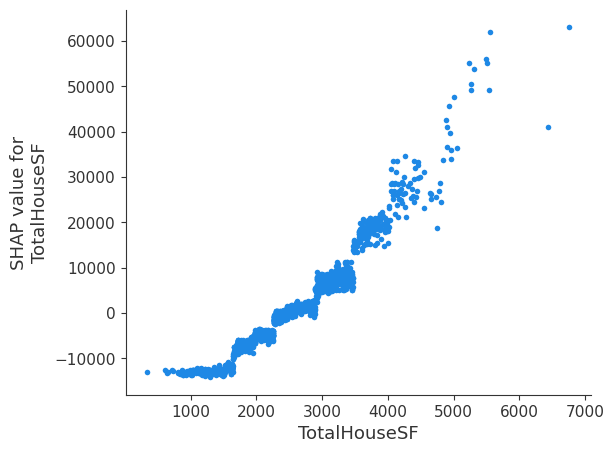

In [39]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index=None, show=False)


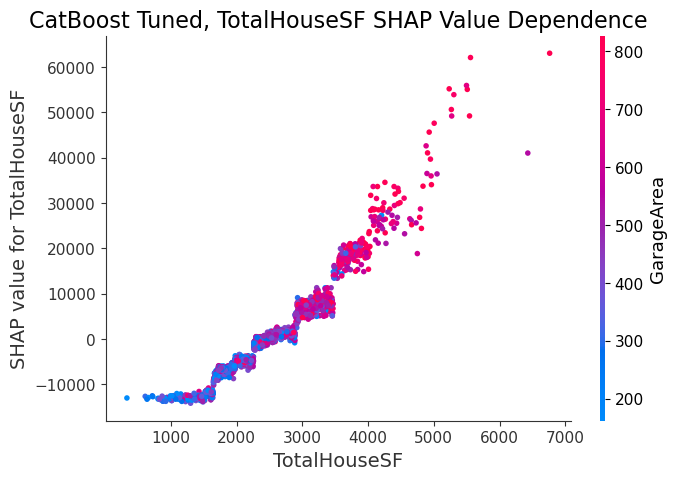

In [28]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index="GarageArea", show=False)

plt.title('CatBoost Tuned, TotalHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);
plt.show()

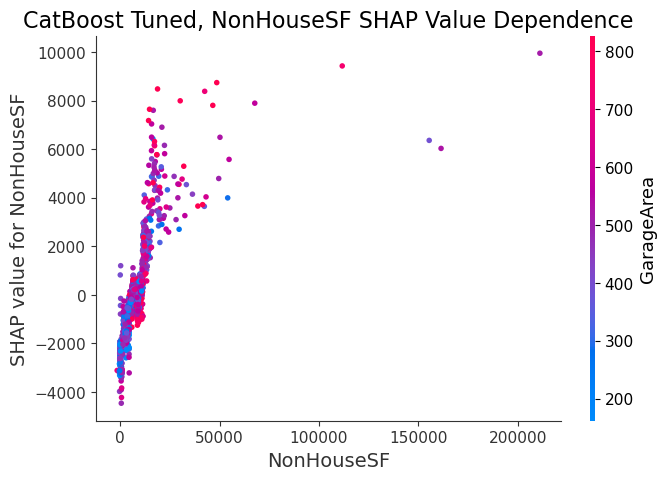

In [29]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("NonHouseSF", shap_values, X, interaction_index="GarageArea", show=False)

plt.title('CatBoost Tuned, NonHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for NonHouseSF', fontsize=14)
plt.xlabel('NonHouseSF', fontsize=14);
plt.show()

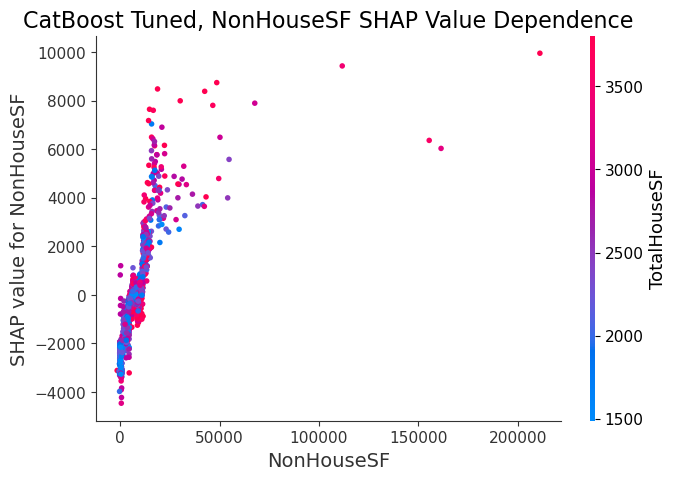

In [30]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("NonHouseSF", shap_values, X, interaction_index="TotalHouseSF", show=False)

plt.title('CatBoost Tuned, NonHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for NonHouseSF', fontsize=14)
plt.xlabel('NonHouseSF', fontsize=14);
plt.show()

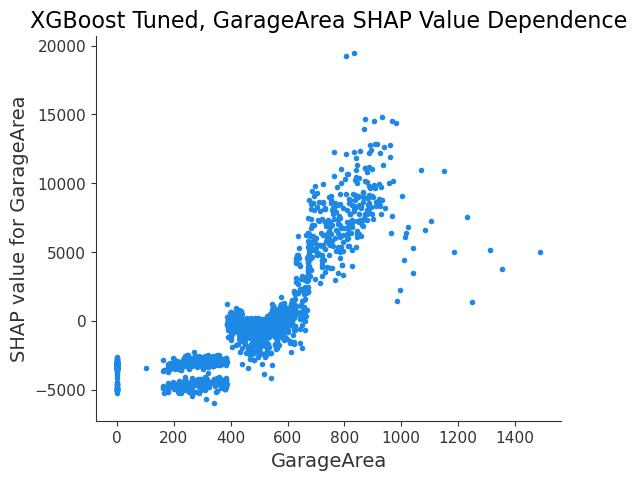

In [40]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("GarageArea", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, GarageArea SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for GarageArea', fontsize=14)
plt.xlabel('GarageArea', fontsize=14);
plt.show()

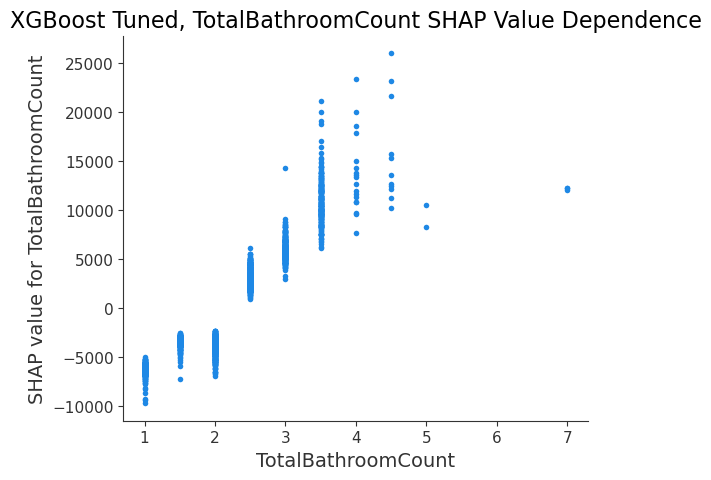

In [41]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalBathroomCount", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, TotalBathroomCount SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for TotalBathroomCount', fontsize=14)
plt.xlabel('TotalBathroomCount', fontsize=14);
plt.show()

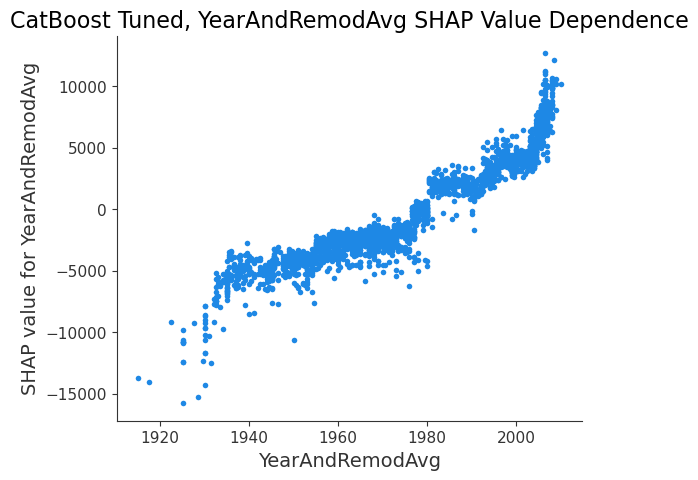

In [33]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("YearAndRemodAvg", shap_values, X, interaction_index=None, show=False)

plt.title('CatBoost Tuned, YearAndRemodAvg SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for YearAndRemodAvg', fontsize=14)
plt.xlabel('YearAndRemodAvg', fontsize=14);
plt.show()

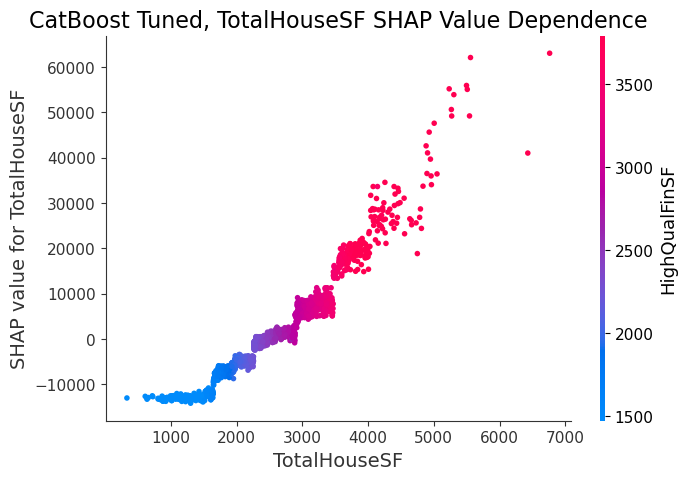

In [34]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("TotalHouseSF", shap_values, X, interaction_index='HighQualFinSF', show=False)

plt.title('CatBoost Tuned, TotalHouseSF SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for TotalHouseSF', fontsize=14)
plt.xlabel('TotalHouseSF', fontsize=14);
plt.show()

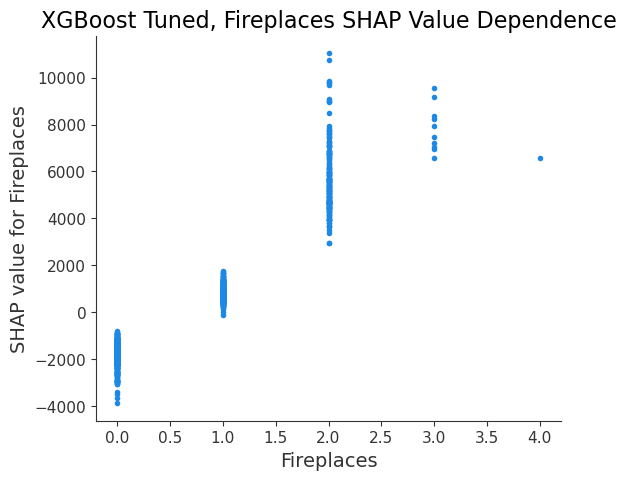

In [42]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("Fireplaces", shap_values, X, interaction_index=None, show=False)

plt.title('XGBoost Tuned, Fireplaces SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for Fireplaces', fontsize=14)
plt.xlabel('Fireplaces', fontsize=14);
plt.show()

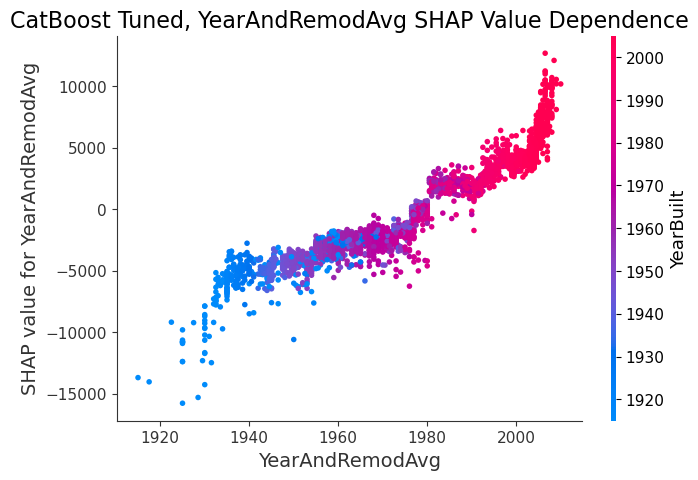

In [36]:
#YearBuilt LowQualFinSF

#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("YearAndRemodAvg", shap_values, X, interaction_index="YearBuilt", show=False)

plt.title('CatBoost Tuned, YearAndRemodAvg SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for YearAndRemodAvg', fontsize=14)
plt.xlabel('YearAndRemodAvg', fontsize=14);
plt.show()

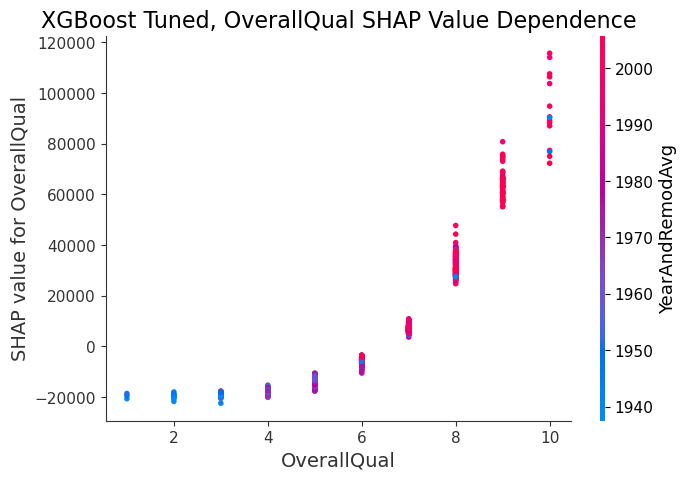

In [45]:
#Shap Dependence Plot vs "Overall Qual"
shap.dependence_plot("OverallQual", shap_values, X, interaction_index="YearAndRemodAvg", show=False)

plt.title('XGBoost Tuned, OverallQual SHAP Value Dependence', fontsize=16)

plt.ylabel('SHAP value for OverallQual', fontsize=14)
plt.xlabel('OverallQual', fontsize=14);
plt.show()